<a href="https://colab.research.google.com/github/CursingRabbit/backpropagation_test/blob/master/MrBeamDataViewer_v0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install LightPipes

In [4]:
pip install laserbeamsize

  Created wheel for laserbeamsize: filename=laserbeamsize-1.0.1-py2.py3-none-any.whl size=5730 sha256=88cc2af12f8715c8d59b9741a8da4412bf0fcbc428ed44fce220ee735b795e22
  Stored in directory: /root/.cache/pip/wheels/f6/37/f2/a77f2cb1ab5998f5678c1df9cf58bb0462179aa2299e1a7839
Successfully built laserbeamsize


In [5]:
from pathlib import Path, PureWindowsPath
import re

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'errorbar.capsize': 2})
import matplotlib.transforms as transforms
import matplotlib.gridspec as gridspec
from mpl_toolkits import mplot3d

import numpy as np
from numpy import genfromtxt
import os
import ipywidgets as widgets
from ipywidgets import interact,interactive, interactive_output

from scipy.optimize import curve_fit
from scipy import ndimage
from scipy import interpolate
from scipy import special

import glob
import pandas as pd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
#%%

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.colorbar import Colorbar

import laserbeamsize as lbs
import math

from sklearn.linear_model import LinearRegression

import cv2

import LightPipes as lp

# Importing files which were generating with MrBeam's macro into a pandas dataframe

In [6]:
# use data stored in own google drive location
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
# root_path = 'gdrive/My Drive/Colab Notebooks/VOXEL-KB/'  #change dir to your project folder

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [576]:
# get from the cloud, in this case from a public github repository by me
!wget https://github.com/CursingRabbit/backpropagation_test/blob/master/extraction.zip

--2019-10-23 22:53:19--  https://github.com/CursingRabbit/backpropagation_test/blob/master/extraction.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘extraction.zip.1’

extraction.zip.1        [  <=>               ]  62.34K   172KB/s    in 0.4s    

2019-10-23 22:53:21 (172 KB/s) - ‘extraction.zip.1’ saved [63836]



In [46]:
# add local zip with foldertree of csv files
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving extraction.zip to extraction.zip
User uploaded file "extraction.zip" with length 970794 bytes


In [49]:
!unzip extraction.zip

Archive:  extraction.zip
  inflating: Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/VOXEL_20180411/extraction/C_/Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/VOXEL_20180411/sequence10/BeamParameters_columns.csv  
  inflating: Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/VOXEL_20180411/extraction/C_/Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/VOXEL_20180411/sequence10/clipped/BeamParameters_Legendre_grid_x21y21_all.csv  
  inflating: Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/VOXEL_20180411/extraction/C_/Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/VOXEL_20180411/sequence10/clipped/BeamParameters_Legendre_grid_x31y18_all.csv  
  inflating: Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/VOXEL_20180411/extraction/C_/Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/VOXEL_20180411/sequence10/clipped/BeamParameters_Legendre_grid_x31y21_all.csv  
  inflating: Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/VOXEL_20180411/extraction/C_/Users/Thomas/OneDrive/PhD/VOXEL-KB/dat

In [0]:
csvpath_str = 'Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/'
csvpath = Path(csvpath_str)

In [50]:
%ls

extraction.zip  gdrive/  sample_data/  Users/


In [51]:
%pwd

'/content'

In [0]:
os.chdir('/content')

In [0]:
csvpath_str = 'gdrive/My Drive/Colab Notebooks/VOXEL-KB/data/XUV-WFS/'
csvpath = Path(csvpath_str)

In [11]:
csvpath

PosixPath('gdrive/My Drive/Colab Notebooks/VOXEL-KB/data/XUV-WFS')

In [53]:
sorted(csvpath.glob('**/seq.*_BeamParameters*.csv'))  
# if working directory is not '/content' it will not find anything. change back with os.chdir('/content')

[PosixPath('Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/VOXEL_20180411/extraction/C_/Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/VOXEL_20180411/sequence1/seq.2_BeamParameters_clipped_0_offset_0_subAOI_auto_gridsize_39_auto.csv'),
 PosixPath('Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/VOXEL_20180411/extraction/C_/Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/VOXEL_20180411/sequence10/seq.10_BeamParameters_clipped_0_offset_0_subAOI_auto_gridsize_39_auto.csv'),
 PosixPath('Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/VOXEL_20180411/extraction/C_/Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/VOXEL_20180411/sequence10/seq.1_BeamParameters_clipped_0_offset_0_subAOI_auto_gridsize_39_auto.csv'),
 PosixPath('Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/VOXEL_20180411/extraction/C_/Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/VOXEL_20180411/sequence10/seq.2_BeamParameters_clipped_0_offset_0_subAOI_auto_gridsize_39_auto.csv'),
 PosixPath('Users/Thomas/OneDrive/PhD/VOXEL-

In [90]:
# csvpath = Path('/Users/Thomas/OneDrive/PhD/VOXEL-KB/.csv')

# dfDM = pd.read_csv(csvpath)
# dfDM['date']=dfDM.apply(lambda row: pd.to_datetime(row.date), axis=1)



# csvpath = Path('/Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WFS/')
# csvpath_str = 'gdrive/My Drive/Colab Notebooks/VOXEL-KB/data/XUV-WFS/'
# csvpath = Path(csvpath_str)
# os.chdir(csvpath) # this will mess up the colab runtime!!!! is it because we are giving it the Path object?? maybe it's not happening when a string is given?

  
BeamParametersFiles = csvpath.glob('**/seq.*_BeamParameters*.csv')
CellSumsFiles = csvpath.glob('**/seq.*_CellSums*.csv')
wavefrontFiles = csvpath.glob('**/seq.*_wavefront*.csv')

if sorted(csvpath.glob('**/seq.*_BeamParameters*.csv')) != []:
    headerfile = sorted(csvpath.glob('**/BeamParameters_columns.csv'))[0]
    file_encoding = 'cp1252'
    headerdf = pd.read_csv(headerfile, skipinitialspace=True, encoding=file_encoding)
    dfXUV1 = pd.concat([pd.read_csv(f, header=None, skipinitialspace=True) for f in sorted(csvpath.glob('**/seq.*_BeamParameters*.csv'))], ignore_index=True)
    dfXUV1.columns = headerdf.columns
    dfXUV1['XUV-BeamParametersFile']=sorted(csvpath.glob('**/seq.*_BeamParameters*.csv'))
    dfXUV1['XUV-CellSumsFile'] = sorted(csvpath.glob('**/seq.*_CellSums*.csv'))
    dfXUV1['XUV-wavefrontFile'] = sorted(csvpath.glob('**/seq.*_wavefront*.csv'))
    dfXUV1['dataset'] = dfXUV1.apply(lambda row: row['XUV-BeamParametersFile'].parts[-3], axis=1)
    dfXUV1['sequenceid'] = dfXUV1.apply(lambda row: int(re.split('(\d+)',row['XUV-BeamParametersFile'].parts[-2])[1]), axis=1)
    dfXUV1['XUV_imageid'] = dfXUV1.apply(lambda row: int(row['XUV-BeamParametersFile'].parts[-1].split('.')[1].split('_')[0]), axis=1)
    dfXUV1['date']=dfXUV1.apply(lambda row: pd.to_datetime(re.split('(\d+)',row['XUV-BeamParametersFile'].parts[-3])[1]), axis=1)
    
    dfXUV1['XUV_clipped'] = dfXUV1.apply(lambda row: int(row['XUV-BeamParametersFile'].parts[-1].split('_')[3]), axis=1)
    dfXUV1['XUV_offset'] = dfXUV1.apply(lambda row: int(row['XUV-BeamParametersFile'].parts[-1].split('_')[5]), axis=1)
    dfXUV1['XUV_subAOI_mode'] = dfXUV1.apply(lambda row: row['XUV-BeamParametersFile'].parts[-1].split('_')[7], axis=1)
    
    dfXUV1['XUV_gridsize'] = dfXUV1.apply(lambda row: int(row['XUV-BeamParametersFile'].parts[-1].split('_')[9]), axis=1)
    dfXUV1['XUV_gridtracking'] = dfXUV1.apply(lambda row: row['XUV-BeamParametersFile'].parts[-1].split('_')[10].split('.')[0], axis=1)


if sorted(csvpath.glob('**/av*_BeamParameters*.csv')) != []:
    print('There are XUV averages!')
    headerfile = sorted(csvpath.glob('/**/BeamParameters_columns.csv'))[0]
    file_encoding = 'cp1252'
    dfXUV2 = pd.concat([pd.read_csv(f, header=None, skipinitialspace=True) for f in sorted(csvpath.glob('**/av*_BeamParameters*.csv'))], ignore_index=True)
    dfXUV2.columns = headerdf.columns
    dfXUV2['XUV-BeamParametersFile']=sorted(csvpath.glob('**/av*_BeamParameters*.csv'))
    dfXUV2['dataset']=dfXUV2.apply(lambda row: row['XUV-BeamParametersFile'].parts[-2], axis=1)
    dfXUV2['sequenceid'] = dfXUV2.apply(lambda row: int(re.split('(\d+)',row['XUV-BeamParametersFile'].parts[-1].split('_')[1])[1]), axis=1)
    dfXUV2['XUV-CellSumsFile'] = sorted(csvpath.glob('**/av*_CellSums*.csv'))
    dfXUV2['XUV-wavefrontFile'] = sorted(csvpath.glob('**/av*_wavefront*.csv'))
    dfXUV2['XUV_imageid']=dfXUV2.apply(lambda row: 0, axis=1)
    dfXUV2['date']=dfXUV2.apply(lambda row: pd.to_datetime(re.split('(\d+)',row['XUV-BeamParametersFile'].parts[-2])[1]), axis=1)
    
    dfXUV2['XUV_clipped'] = dfXUV2.apply(lambda row: int(row['XUV-BeamParametersFile'].parts[-1].split('_')[4]), axis=1)
    dfXUV2['XUV_offset'] = dfXUV2.apply(lambda row: int(row['XUV-BeamParametersFile'].parts[-1].split('_')[6]), axis=1)
    dfXUV2['XUV_subAOI_mode'] = dfXUV2.apply(lambda row: row['XUV-BeamParametersFile'].parts[-1].split('_')[8], axis=1)
    
    dfXUV2['XUV_gridsize'] = dfXUV2.apply(lambda row: int(row['XUV-BeamParametersFile'].parts[-1].split('_')[10]), axis=1)
    dfXUV2['XUV_gridtracking'] = dfXUV2.apply(lambda row: row['XUV-BeamParametersFile'].parts[-1].split('_')[11].split('.')[0], axis=1)
    dfXUV = pd.concat([dfXUV1,dfXUV2])
else:
    print('There are NO XUV averages!')
    dfXUV = dfXUV1


dfXUV.replace(['None', 'nan', 'Nan'], np.nan, inplace=True)


dfXUV['xuv_wavelength (nm)'] = dfXUV.apply(lambda row: 32, axis=1)

dfXUV['XUV-Astigmatism_Y^2-X^2 (lambda)']=dfXUV.apply(lambda row: row['XUV-Astigmatism_Y^2-X^2 (mm)']/1000*1e6/32, axis=1)
dfXUV['XUV-Astigmatism_XY (lambda)']=dfXUV.apply(lambda row: row['XUV-Astigmatism_XY (mm)']/1000*1e6/32, axis=1)
dfXUV['XUV-Coma_X (lambda)']=dfXUV.apply(lambda row: row['XUV-Coma_X (mm)']/1000*1e6/32, axis=1)
dfXUV['XUV-Coma_Y (lambda)']=dfXUV.apply(lambda row: row['XUV-Coma_Y (mm)']/1000*1e6/32, axis=1)
dfXUV['XUV-Triangular_Coma (lambda)']=dfXUV.apply(lambda row: row['XUV-Triangular_Coma (mm)']/1000*1e6/32, axis=1)
dfXUV['XUV-Quadratic_Astigmatism (lambda)']=dfXUV.apply(lambda row: row['XUV-Quadratic_Astigmatism (mm)']/1000*1e6/32, axis=1)
dfXUV['XUV-Spher_Aberration (lambda)']=dfXUV.apply(lambda row: row['XUV-Spher_Aberration (mm)']/1000*1e6/32, axis=1)
dfXUV['XUV-5th_Spher_Aberration (lambda)']=dfXUV.apply(lambda row: row['XUV-5th_Spher_Aberration (mm)']/1000*1e6/32, axis=1)
dfXUV['XUV-PV_Irregularity (lambda)']=dfXUV.apply(lambda row: row['XUV-PV_Irregularity (nm)']/32, axis=1)
dfXUV['XUV-rms_Deformation (lambda)']=dfXUV.apply(lambda row: row['XUV-rms_Deformation (nm)']/32, axis=1)





# df = pd.merge(df,dfDM, how='outer')
df = dfXUV

df['sequenceid'] = df['sequenceid'].astype(str).astype(int)

# df['XUV-TotalEnergy/shot (cnts)']=df.apply(lambda row: row['XUV-TotalEnergy']/row['XUV exposure'], axis=1)

df.replace(['None', 'nan', 'Nan'], np.nan, inplace=True)

print('done!')

There are NO XUV averages!
done!


In [0]:
df = df.rename(index=str, columns={
                                  'XUV-Astigmatism_Y^2-X^2 (lambda)': 'XUV Astigmatism 0°/90° / $\lambda$',
                                  'XUV-Astigmatism_XY (lambda)': 'XUV Astigmatism $\pm$45° / $\lambda$',
                                  'XUV-Coma_X (lambda)': 'XUV Horizontal Coma / $\lambda$',
                                  'XUV-Coma_Y (lambda)': 'XUV Vertical Coma / $\lambda$',
                                  'XUV-Triangular_Coma (lambda)': 'XUV Triangular Coma / $\lambda$',
                                  'XUV-Quadratic_Astigmatism (lambda)': 'XUV Quadratic Astigmatism / $\lambda$',
                                  'XUV-Spher_Aberration (lambda)': 'XUV Spher. Aberration / $\lambda$',
                                  'XUV-5th_Spher_Aberration (lambda)': 'XUV 5th Spher. Aberration / $\lambda$', 
                                  'XUV-Defocus (mm)': 'XUV Defocus / mm', 
                                  'XUV-Rayleigh_length_X (mm)': 'XUV Rayleigh length X / mm', 
                                  'XUV-Rayleigh_length_Y (mm)': 'XUV Rayleigh length Y / mm',                                  
                                  'XUV-Waist_diameter_X (mm)': 'XUV Waist diameter X / mm',
                                  'XUV-Waist_diameter_Y (mm)': 'XUV Waist diameter Y / mm',
                                  'XUV-Waist_difference (RL)': 'XUV Waist difference / RL',
                                  'XUV-Divergence_X (mrad)': 'XUV Divergence X / mrad',
                                  'XUV-Divergence_Y (mrad)': 'XUV Divergence Y / mrad',
                                  'XUV-TotalEnergy/shot (cnts)': 'XUV TotalEnergy/shot / cnts',
                                  'XUV-CenterX': 'XUV Center X',
                                  'XUV-CenterY': 'XUV Center Y',
                                  'XUV-Waist_position_X (mm)': 'XUV Waist position X / mm',
                                  'XUV-Waist_position_Y (mm)': 'XUV Waist position Y / mm',
                                  'XUV-rms_Deformation (lambda)': 'XUV rms Deformation / $\lambda$',
                                  'XUV-PV_Irregularity (lambda)': 'XUV PV Irregularity / $\lambda$'
                                  })



In [92]:
df

,XUV-Identifier,XUV-FileName,XUV-TotalEnergy,XUV Center X,XUV Center Y,XUV-Radius_for_Zernike_evaluation (mm),XUV-Tilt_X (mm),XUV-Tilt_Y (mm),XUV-Zernike_Defocus_coeff (mm),XUV-Astigmatism_Y^2-X^2 (mm),XUV-Astigmatism_XY (mm),XUV-Coma_X (mm),XUV-Coma_Y (mm),XUV-Triangular_Coma (mm),XUV-Quadratic_Astigmatism (mm),XUV-Spher_Aberration (mm),XUV-5th_Spher_Aberration (mm),XUV-PV_Irregularity (nm),XUV Defocus / mm,XUV-rms_Deformation (nm),XUV-General_astigmatism (),XUV Rayleigh length X / mm,XUV Rayleigh length Y / mm,XUV-Slope_max (mrad),XUV-Slope_rms (mrad),XUV-M^4 (),XUV-M^2_X (),XUV-M^2_Y (),XUV Divergence X / mrad,XUV Divergence Y / mrad,XUV-Beam_width_X (mm),XUV-Beam_width_Y (mm),XUV Waist position X / mm,XUV Waist position Y / mm,XUV Waist difference / RL,XUV Waist diameter X / mm,XUV Waist diameter Y / mm,XUV-M^2 (45°),XUV-M^2 (135°),XUV-Divergence_45° (mrad),XUV-Divergence_135° (mrad),XUV-Beam_width_45° (mm),XUV-Beam_width_135° (mm),XUV-Waist_position_45° (mm),XUV-Waist_position_135° (mm),XUV-Waist_difference (45°),XUV-Waist_diameter_45° (mm),XUV-Waist_diameter_135° (mm),XUV-BeamParametersFile,XUV-CellSumsFile,XUV-wavefrontFile,dataset,sequenceid,XUV_imageid,date,XUV_clipped,XUV_offset,XUV_subAOI_mode,XUV_gridsize,XUV_gridtracking,xuv_wavelength (nm),XUV Astigmatism 0°/90° / $\lambda$,XUV Astigmatism $\pm$45° / $\lambda$,XUV Horizontal Coma / $\lambda$,XUV Vertical Coma / $\lambda$,XUV Triangular Coma / $\lambda$,XUV Quadratic Astigmatism / $\lambda$,XUV Spher. Aberration / $\lambda$,XUV 5th Spher. Aberration / $\lambda$,XUV PV Irregularity / $\lambda$,XUV rms Deformation / $\lambda$
0,VOXEL_20180411_seq.2_BeamParameters_clipped_0_...,seq.2.tif,8.008222e+07,0.008296,0.007612,6717.514421,0.609219,1.231573,-28.879280,-0.629985,0.086706,0.264549,0.397553,0.325090,0.013672,-0.007784,0.003763,1094.139456,390.716951,0.0,150.448040,3.766775,6.938238,0.999842,7.628265,2769.703557,61.227359,45.805219,25.734634,16.400721,9.961388,6.477642,-387.062701,-394.899831,1.464198,0.096937,0.113792,65.260472,72.587272,20.954062,22.185182,8.148144,8.648517,-388.810353,-389.786719,0.161855,0.126894,0.133308,Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WF...,Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WF...,Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WF...,VOXEL_20180411,1,2,2018-04-11,0,0,auto,39,auto,32,-19.687031,2.709562,8.267156,12.423531,10.159062,0.427250,-0.243250,0.117594,34.191858,0.0
1,VOXEL_20180411_seq.10_BeamParameters_clipped_0...,seq.10.tif,9.547066e+07,0.007475,0.007091,6717.514421,1.312446,1.642603,-28.804361,-0.410367,0.098186,0.260694,0.466812,0.372305,0.018607,-0.008265,0.004630,961.365621,391.672565,0.0,16.396455,3.917051,7.344083,0.999876,8.088632,4223.816854,66.160844,64.711396,26.233181,18.947488,10.192611,7.459549,-388.519155,-393.627453,0.907244,0.102757,0.139152,72.921599,77.280408,23.235548,22.523241,9.059581,8.801034,-389.862912,-390.704139,0.143677,0.127868,0.139797,Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WF...,Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WF...,Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WF...,VOXEL_20180411,10,10,2018-04-11,0,0,auto,39,auto,32,-12.823969,3.068312,8.146688,14.587875,11.634531,0.581469,-0.258281,0.144687,30.042676,0.0
2,VOXEL_20180411_seq.1_BeamParameters_clipped_0_...,seq.1.tif,9.428321e+07,0.007425,0.007019,6717.514421,1.311845,1.603892,-28.821772,-0.369693,0.102027,0.261920,0.443549,0.353520,0.031339,-0.019997,0.001548,929.489814,391.673638,0.0,13.062956,3.918218,7.255791,0.999878,8.127347,4303.085714,65.925790,66.214106,26.182638,19.282481,10.172464,7.590916,-388.499685,-393.602175,0.913278,0.102589,0.139910,73.707743,77.787620,23.306388,22.675029,9.086550,8.862033,-389.834614,-390.779262,0.161577,0.128854,0.139773,Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WF...,Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WF...,Users/Thomas/OneDrive/PhD/VOXEL-KB/data/XUV-WF...,VOXEL_20180411,10,1,2018-04-11,0,0,auto,39,auto,32,-11.552906,3.188344,8.185000,13.860906,11.047500,0.979344,-0.62490

# Function definintions

In [0]:
def CellSumsFile_to_arr(file):
    image = genfromtxt(file, encoding='cp1252',
                       delimiter=',', skip_header=2, dtype=None)
    # neglect last column which is just empty after a comma
    image = image[:, 0:-1]
    image = image / np.nanmax(image)
    # ascii is saved flipped horizontally
    image = np.flipud(image)
    return image


def roll_image(X, dx, dy):
        X = np.roll(X, dy, axis=0)
        X = np.roll(X, dx, axis=1)
        return X
    
def roll_image_arr(X, dx, dy):
        X = np.roll(X, dy, axis=1)
        X = np.roll(X, dx, axis=2)
        return X       


def wavefrontFile_to_arr(file):
    wavefront_mm = genfromtxt(file, encoding='cp1252',
                              delimiter=',', skip_header=2, dtype=None)
    # neglect last column which is just empty after a comma
    wavefront_mm = wavefront_mm[:, 0:-1]
    # was multiplied in MrBeam Macro by 10 to get more digits
    wavefront_mm = wavefront_mm / 10
    # ascii is saved flipped horizontally
    wavefront_mm = np.flipud(wavefront_mm)
    return wavefront_mm

In [0]:
def CellSumsFile_to_arr(file):
    image = genfromtxt(file, encoding='cp1252',
                       delimiter=',', skip_header=2, dtype=None)
    # neglect last column which is just empty after a comma
    image = image[:, 0:-1]
    image = image / np.nanmax(image)
    return image


def wavefrontFile_to_arr(file):
    wavefront_mm = genfromtxt(file, encoding='cp1252',
                              delimiter=',', skip_header=2, dtype=None)
    # neglect last column which is just empty after a comma
    wavefront_mm = wavefront_mm[:, 0:-1]
    # was multiplied in MrBeam Macro by 10 to get more digits
    wavefront_mm = wavefront_mm / 10
    return wavefront_mm


def pre_propagate(intensity,wavefront_lambda,pad_width,NewN,repeatBlurring):

    # pad and resize intensity and wavefront:

#     pad_width = 1
    intensity_pad = np.pad(intensity, pad_width=pad_width, mode='constant', constant_values=0)
    wavefront_lambda_pad = np.pad(wavefront_lambda, pad_width=pad_width, mode='constant', constant_values=0)

    intensity_pad = np.nan_to_num(intensity_pad)
    wavefront_lambda_pad = np.nan_to_num(wavefront_lambda_pad)
    
    GridDimension = np.shape(intensity_pad)[0]

    do_fliplr = False # True to have the same appearence like in MrBeams backpropagation
    if do_fliplr == True:
        intensity_pad = np.fliplr(intensity_pad)
        wavefront_lambda_pad = np.fliplr(wavefront_lambda_pad)

    
    interpolation = cv2.INTER_CUBIC
    #interpolation = cv2.INTER_LANCZOS4
    #interpolation = cv2.INTER_NEAREST

    intensity_pad_resize_nearest = cv2.resize(intensity_pad, dsize=(NewN,NewN), interpolation=cv2.INTER_NEAREST)
    intensity_pad_resize = cv2.resize(intensity_pad, dsize=(NewN,NewN), interpolation=interpolation)
    for i in range(repeatBlurring):
      intensity_pad_resize = cv2.GaussianBlur(intensity_pad_resize,(5,5),0)
    
    wavefront_lambda_pad_resize = cv2.resize(wavefront_lambda_pad, dsize=(NewN,NewN), interpolation=interpolation)

    intensity_pad_resize_nearest[intensity_pad_resize_nearest>0] = 1
    mask_resize = intensity_pad_resize_nearest

    intensity_pad_resize = np.multiply(intensity_pad_resize,mask_resize)
    wavefront_lambda_pad_resize = np.multiply(wavefront_lambda_pad_resize,mask_resize)

    
    

    wavefront_pad_resize_rad = wavefront_lambda_pad_resize * (2*math.pi)

    return intensity_pad_resize, wavefront_pad_resize_rad, GridDimension



def propagate(wavelength_nm, intensity, phase_rad, defocus_mm, V, z1_mm, GridDimension, GridPitch_um, R):
    
    
    GridPitch = GridPitch_um*1e-6
    GridSize = GridDimension*GridPitch
    
    N = 256
    size = GridSize
    wavelength = wavelength_nm*1e-9
#     R = GridSize/2
    
    F0=lp.Begin(size,wavelength,N)
    F0=lp.SubPhase(phase_rad,F0)
    F0=lp.SubIntensity(intensity,F0)
    
    F0=lp.CircAperture(R, 0, 0, F0)

    if np.isinf(defocus_mm) == False:
        F0 = lp.Lens(defocus_mm*1e-3,0,0, F0)

    I=lp.Intensity(1,F0)
    wavefront_rad=lp.Phase(F0)
    #wavefront_rad=lp.PhaseUnwrap(wavefront_rad)
    
    z1 = z1_mm*1e-3
    z2 = -V*z1

    f = V*z1 / (V-1)

    F1 = lp.Lens(f,0,0,F0)

    F1 = lp.Forvard(z2,F1)

    I=lp.Intensity(1,F1)
    wavefront_rad=lp.Phase(F1)
    #wavefront_rad=lp.PhaseUnwrap(wavefront_rad)
    
    image_size_x_m = GridSize / V

    
    
    return (I,wavefront_rad, image_size_x_m, F1)

# intensity_pad_resize, wavefront_pad_resize_rad = pre_propagate(intensity,wavefront_lambda,NewN=256)
# # create caustic
# defocus_mm = -0.3694
# V=9.6

# I_arr = []
# wavefront_rad_arr = []
# for z1_mm in np.arange(347.5,385.0,0.5):
#     I, wavefront_rad = propagate(intensity_pad_resize, wavefront_pad_resize_rad, defocus_mm, V, z1_mm)
#     I_arr.append(I)
#     wavefront_rad_arr.append(wavefront_rad)

In [0]:
def generate_propagation_arrays(wavelength_nm, intensity_pad_resize, wavefront_pad_resize_rad, defocus_mm, V, z_mm_arr, GridDimension, GridPitch_um, do_fliplr, do_flipud, transmission, profilewidth, use_foursigma, use_Gaussianfit, R):
    

    magn_arr = []

    image_list  = []
    image_norm_list = []
    image_intensity_list = []
    wavefront_rad_list = []
    image_size_x_m = []
    image_size_y_m = []
    pixelsize_m = []
    maxposx_arr = []
    maxposy_arr = []
    fwhm_x_um_arr = []
    fwhm_y_um_arr = []
    sigma_x_um_arr = []
    sigma_y_um_arr = []
    radiusx_pos_arr = []
    radiusx_neg_arr = []
    radiusy_pos_arr = []
    radiusy_neg_arr = []
    PeakIntensity_arr = []
    x0_px_arr = []
    y0_px_arr = []
    phi_arr = []
    idx = 0
    
    
    # create caustic
#     defocus_mm = -0.3694
#     V=9.6

    I_arr = []
    
    for z1_mm in z_mm_arr:
        image_norm, wavefront_rad, image_size_x_m, Field = propagate(wavelength_nm, intensity_pad_resize, wavefront_pad_resize_rad, defocus_mm, V, z1_mm, GridDimension, GridPitch_um, R)
        
        image_norm = image_norm/np.max(image_norm)
        
        if do_fliplr == True:
            image_norm = np.fliplr(image_norm)
            wavefront_rad = np.fliplr(wavefront_rad)

        if do_flipud == True:
            image_norm = np.flipud(image_norm)
            wavefront_rad = np.flipud(wavefront_rad)

        image_norm_list.append(image_norm)        
        wavefront_rad_list.append(wavefront_rad)

        magn_arr.append(V)


        

        pixelsize_m.append(image_size_x_m / image_norm.shape[0])


        maxposx = np.where(image_norm==1)[1][0]
        # maxposx=0
        maxposx_arr.append(maxposx)
        maxposy = np.where(image_norm==1)[0][0]
        # maxposy=0
        maxposy_arr.append(maxposy)

        halfposx = np.where(image_norm[maxposy,:]>0.5)[0]
        halfposy = np.where(image_norm[:,maxposx]>0.5)[0]

        radiusx_pos = 0
        k = 0
        while np.where(halfposx == maxposx)[0][0]+1 + k < len(halfposx) and halfposx[np.where(halfposx == maxposx)[0][0]+1 + k]-halfposx[np.where(halfposx == maxposx)[0][0] + k] < 2:
            radiusx_pos = radiusx_pos + 1
            k = k + 1
        radiusx_pos_arr.append(radiusx_pos)

        radiusx_neg = 0
        k = 0
        while np.where(halfposx == maxposx)[0][0] - k - 1 >= 0 and halfposx[np.where(halfposx == maxposx)[0][0] - k]-halfposx[np.where(halfposx == maxposx)[0][0] - k -1] < 2:
            radiusx_neg = radiusx_neg + 1
            k = k + 1
        radiusx_neg_arr.append(radiusx_neg)

        fwhm_x_px = radiusx_pos + radiusx_neg + 1


        radiusy_pos = 0
        k = 0
        while np.where(halfposy == maxposy)[0][0]+1 + k < len(halfposy) and halfposy[np.where(halfposy == maxposy)[0][0]+1 + k]-halfposy[np.where(halfposy == maxposy)[0][0] + k] < 2:
            radiusy_pos = radiusy_pos + 1
            k = k + 1
        radiusy_pos_arr.append(radiusy_pos)

        radiusy_neg = 0
        k = 0
        while np.where(halfposy == maxposy)[0][0] - k - 1 >= 0 and halfposy[np.where(halfposy == maxposy)[0][0] - k]-halfposy[np.where(halfposy == maxposy)[0][0] - k -1] < 2:
            radiusy_neg = radiusy_neg + 1
            k = k + 1
        radiusy_neg_arr.append(radiusy_neg)

        fwhm_x_px = radiusx_pos + radiusx_neg + 1
        fwhm_x_um = fwhm_x_px * pixelsize_m[0] * 1e6
        fwhm_x_um_arr.append(fwhm_x_um)

        fwhm_y_px = radiusy_pos + radiusy_neg + 1
        fwhm_y_um = fwhm_y_px * pixelsize_m[0] * 1e6
        fwhm_y_um_arr.append(fwhm_y_um)


        # using 4 sigma width

        if use_foursigma == True:
            xc_found, yc_found, dx_found, dy_found, phi_found = lbs.beam_size(np.flipud(image_norm)*25500) # flipud because beam_size() calculates for an image with origin upper
            x0_px = xc_found
            y0_px = 255-yc_found # because it was determined for the flipedup image
            sigma_x_px = dx_found / 4
            sigma_y_px = dy_found / 4
            phi_arr.append(phi_found)
        else:
            phi_arr.append(0)                



        def Gauss(x, x0, sigma):
            return 1 * np.exp(-(x - x0)**2 / (2 * sigma**2))

        if profilewidth > 0:
            profile_x = np.mean(image_norm[int(maxposy-profilewidth/2):int(maxposy+profilewidth/2),:], axis=0)
        else:
            profile_x = image_norm[maxposy,:]


        x = np.arange(256)
        y = profile_x



        if use_Gaussianfit == True:
            #calculate parameter of fit function with scipy's curve fitting algorithm
            popt, pcov = curve_fit(Gauss, x, y, p0=[maxposx, 1/2.3548*fwhm_x_px])
            x0_px = popt[0]
            sigma_x_px = popt[1]

        x0_px_arr.append(x0_px)
        x0_um = x0_px * pixelsize_m[0] * 1e6
        sigma_x_um = sigma_x_px * pixelsize_m[0] * 1e6
        sigma_x_um_arr.append(sigma_x_um)

        if profilewidth > 0:
            profile_y = np.mean(image_norm[:,int(maxposx-profilewidth/2):int(maxposx+profilewidth/2)], axis=1)
        else:
            profile_y = image_norm[:,maxposx]
        x = np.arange(256)
        y = profile_y
        #calculate parameter of fit function with scipy's curve fitting algorithm
        if use_Gaussianfit == True:
            popt, pcov = curve_fit(Gauss, x, y, p0=[maxposy,  1/2.3548*fwhm_y_px])
            y0_px = popt[0]
            sigma_y_px = popt[1]

        y0_px_arr.append(y0_px)
        y0_um = y0_px * pixelsize_m[0] * 1e6
        sigma_y_um = sigma_y_px * pixelsize_m[0] * 1e6
        sigma_y_um_arr.append(sigma_y_um)

        # Calculation PeakIntensity of IR beam
        # see https://www.rp-photonics.com/spotlight_2009_10_03.html and
        # https://www.rp-photonics.com/mode_radius.html and
        # https://www.rp-photonics.com/beam_radius.html

        # if datasetpath == '/Users/Thomas/OneDrive/PhD/VOXEL-KB/XUV-WFS/':
#             Energy = df[(df['dataset']==dataset) & (df['sequenceid']==float(sequenceid))]['XUV TotalEnergy/shot / cnts'].iloc[0]
        
        # to be fixed ... for now use energy, not energy per shot for longer exposures ...
        Energy = df[(df['dataset']==dataset) & (df['sequenceid']==float(sequenceid))]['XUV-TotalEnergy'].iloc[0]
        pulseduration = 1 
        
        
        
        OpticalPower = Energy / pulseduration
        FWHM_x = fwhm_x_um*1e-6
        FWHM_y = fwhm_y_um*1e-6
        beamradius_x = FWHM_x / np.sqrt(2*np.log(2))
        beamradius_y = FWHM_y / np.sqrt(2*np.log(2))
        beamradius_x = 2 * sigma_x_um * 1e-6
        beamradius_y = 2 * sigma_y_um * 1e-6



        EffectiveArea = np.pi * beamradius_x * beamradius_y
        PeakIntensity = 2 * OpticalPower / EffectiveArea * 1e-4  # in W/cm-2
        PeakIntensity_arr.append(PeakIntensity)
        image_intensity = image_norm * PeakIntensity
        image_intensity_list.append(image_intensity)

    #    plt.imshow(image_list[idx])

    image_norm_arr = np.dstack(image_norm_list)
    image_norm_arr = np.rollaxis(image_norm_arr,-1)

    wavefront_rad_arr = np.dstack(wavefront_rad_list)
    wavefront_rad_arr = np.rollaxis(wavefront_rad_arr,-1)

    image_intensity_arr = np.dstack(image_intensity_list)
    image_intensity_arr = np.rollaxis(image_intensity_arr,-1)

    x0_px = np.mean(x0_px_arr)
    y0_px = np.mean(y0_px_arr)

    rollx = int(128 - x0_px)
    rolly = int(128 - y0_px)

    image_norm_arr = roll_image_arr(image_norm_arr, rollx, rolly)
    image_intensity_arr = roll_image_arr(image_intensity_arr, rollx, rolly)


    #PeakIntensity = PeakIntensity_arr[ir_z_idx]
    #propagation = PeakIntensity*ir_image_norm_arr[ir_z_idx]
    #propagation = roll_image(propagation, ir_rollx, ir_rolly)
    #propagation=np.fliplr(propagation)



    #ir_propagation = roll_image(ir_propagation, ir_rollx, ir_rolly)


    
    return image_norm_arr, image_intensity_arr, wavefront_rad_arr, magn_arr, image_size_x_m, pixelsize_m, maxposx_arr, maxposy_arr, fwhm_x_um_arr, fwhm_y_um_arr, sigma_x_um_arr, sigma_y_um_arr, radiusx_pos_arr, radiusx_neg_arr, radiusy_pos_arr, radiusy_neg_arr, PeakIntensity_arr, x0_px_arr, y0_px_arr, phi_arr

In [0]:
def plots(do_plots,do_savefigure,dataset,sequenceid_selection,sequenceid,XUV_imageid,xuv_do_average,xuv_postprocessing,xuv_clipped,xuv_offset,xuv_subAOI_mode,xuv_gridsize,xuv_gridtracking,xuv_z_idx,        
          xuv_PeakIntensity_ScalingPerImage,xuv_PeakIntensity_min,xuv_PeakIntensity_max, xuv_contourlevel,
          xuv_energythreshold,
          xuv_wf_range_auto, xuv_wf_range, 
          xuv_magn, profilewidth,
         xuvwaist_min, xuvwaist_max, xuv_R,
         load_bp_files):


    
    # global xuv_intensity_mean
    # global xuv_wavefront_lambda_mean
    # global xuv_image_intensity_arr
    # global xuv_wavefront_rad_arr
    # global xuv_z_mm_arr
    
    if do_plots == True:
        fig = plt.figure(figsize=(62,40))
        #fig = plt.figure()

        gs = gridspec.GridSpec(4,10, width_ratios=[1,1,1,0.05,1,0.05,1,0.05,0.05,1], height_ratios=[1,1,1,1])
        gs.update(hspace=0.20, wspace=0.20)






        
        xuv_wavelength_nm = 32

        xuv_total_energy = df[(df['dataset'] == dataset) & (
            df['sequenceid'] == sequenceid) & (df['XUV_imageid'] == XUV_imageid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking)]['XUV-TotalEnergy'].tolist()[0]

        xuv_ptv_lambda = df[(df['dataset'] == dataset) & (
            df['sequenceid'] == sequenceid) & (df['XUV_imageid'] == XUV_imageid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking)]['XUV PV Irregularity / $\lambda$'].tolist()[0]

        xuv_rms_lambda = df[(df['dataset'] == dataset) & (
            df['sequenceid'] == sequenceid) & (df['XUV_imageid'] == XUV_imageid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking)]['XUV rms Deformation / $\lambda$'].tolist()[0]


        xuv_intensity_arr = []
        xuv_wavefront_lambda_arr = []
        if xuv_do_average == True:
            xuv_intensity_file_list = df[(df['dataset'] == dataset) & (df['sequenceid'] == sequenceid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking)]['XUV-CellSumsFile'].unique().tolist()
            xuv_wavefront_file_list = df[(df['dataset'] == dataset) & (df['sequenceid'] == sequenceid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking)]['XUV-wavefrontFile'].unique().tolist()
            xuv_total_energy_mean = df[(df['dataset'] == dataset) & (
                df['sequenceid'] == sequenceid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking)]['XUV-TotalEnergy'].mean(axis=0)
            xuv_ptv_lambda_mean = df[(df['dataset'] == dataset) & (
                df['sequenceid'] == sequenceid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking)]['XUV PV Irregularity / $\lambda$'].mean(axis=0)
            xuv_rms_lambda_mean = df[(df['dataset'] == dataset) & (
                df['sequenceid'] == sequenceid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking)]['XUV rms Deformation / $\lambda$'].mean(axis=0)
            xuv_total_energy_std = df[(df['dataset'] == dataset) & (
                df['sequenceid'] == sequenceid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking)]['XUV-TotalEnergy'].std(axis=0)
            xuv_ptv_lambda_std = df[(df['dataset'] == dataset) & (
                df['sequenceid'] == sequenceid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking)]['XUV PV Irregularity / $\lambda$'].std(axis=0)
            xuv_rms_lambda_std = df[(df['dataset'] == dataset) & (
                df['sequenceid'] == sequenceid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking)]['XUV rms Deformation / $\lambda$'].std(axis=0)
        else:
            xuv_intensity_file_list = df[(df['dataset'] == dataset) & (df['sequenceid'] == sequenceid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking) & (df['XUV_imageid'] == XUV_imageid)]['XUV-CellSumsFile'].unique().tolist()
            xuv_wavefront_file_list = df[(df['dataset'] == dataset) & (df['sequenceid'] == sequenceid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking) & (df['XUV_imageid'] == XUV_imageid)]['XUV-wavefrontFile'].unique().tolist()
            xuv_total_energy_mean = df[(df['dataset'] == dataset) & (
                df['sequenceid'] == sequenceid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking) & (df['XUV_imageid'] == XUV_imageid)]['XUV-TotalEnergy'].mean(axis=0)
            xuv_ptv_lambda_mean = df[(df['dataset'] == dataset) & (
                df['sequenceid'] == sequenceid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking) & (df['XUV_imageid'] == XUV_imageid)]['XUV PV Irregularity / $\lambda$'].mean(axis=0)
            xuv_rms_lambda_mean = df[(df['dataset'] == dataset) & (
                df['sequenceid'] == sequenceid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking) & (df['XUV_imageid'] == XUV_imageid)]['XUV rms Deformation / $\lambda$'].mean(axis=0)
            xuv_total_energy_std = df[(df['dataset'] == dataset) & (
                df['sequenceid'] == sequenceid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking) & (df['XUV_imageid'] == XUV_imageid)]['XUV-TotalEnergy'].std(axis=0)
            xuv_ptv_lambda_std = df[(df['dataset'] == dataset) & (
                df['sequenceid'] == sequenceid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking) & (df['XUV_imageid'] == XUV_imageid)]['XUV PV Irregularity / $\lambda$'].std(axis=0)
            xuv_rms_lambda_std = df[(df['dataset'] == dataset) & (
                df['sequenceid'] == sequenceid) & (df['XUV_offset'] == xuv_offset) & (df['XUV_gridsize']==xuv_gridsize) & (df['XUV_gridtracking']==xuv_gridtracking) & (df['XUV_imageid'] == XUV_imageid)]['XUV rms Deformation / $\lambda$'].std(axis=0)
        for xuv_intensity_file in xuv_intensity_file_list:
            xuv_intensity = CellSumsFile_to_arr(xuv_intensity_file)
            xuv_intensity_arr.append(xuv_intensity)
        xuv_intensity_mean = np.mean(xuv_intensity_arr, axis=0)
        xuv_intensity_std = np.std(xuv_intensity_arr, axis=0)
        
        for xuv_wavefront_file in xuv_wavefront_file_list:
            xuv_wavefront_mm = wavefrontFile_to_arr(xuv_wavefront_file)
            xuv_wavefront_lambda = xuv_wavefront_mm/1000 * 1e9 / xuv_wavelength_nm
            xuv_wavefront_lambda_arr.append(xuv_wavefront_lambda)
        xuv_wavefront_lambda_mean = np.mean(xuv_wavefront_lambda_arr, axis=0)
        xuv_wavefront_lambda_std = np.std(xuv_wavefront_lambda_arr, axis=0)

        xuv_peak_lambda = np.nanmax(xuv_wavefront_lambda)
        xuv_valley_lambda = np.nanmin(xuv_wavefront_lambda)
        #xuv_ptv_lambda = np.nanmax(wavefront_lambda)-np.nanmin(wavefront_lambda)




        
        

        ## XUV backpropagation images
        
        if load_bp_files == True:
            datasetpath = '/Users/Thomas/OneDrive/PhD/VOXEL-IR_vs_HH/XUV-WFS/'
            if xuv_do_average == True:
                xuv_image_intensity_arr_arr = []
                xuv_PeakIntensity_arr_arr = []

                for i in range(1,31):
                    (xuv_image_arr, xuv_image_norm_arr, xuv_image_intensity_arr, xuv_z_mm_arr, xuv_magn_arr, xuv_scale_arr, xuv_image_size_x_m, xuv_pixelsize_m, xuv_maxposx_arr, xuv_maxposy_arr, 
                     xuv_fwhm_x_um_arr, xuv_fwhm_y_um_arr, xuv_sigma_x_um_arr, xuv_sigma_y_um_arr, xuv_radiusx_pos_arr, xuv_radiusx_neg_arr, xuv_radiusy_pos_arr, xuv_radiusy_neg_arr, 
                     xuv_PeakIntensity_arr, xuv_x0_px_arr, xuv_y0_px_arr, xuv_phi_arr) = generate_images_from_txt(datasetpath,dataset,sequenceid,i,xuv_postprocessing,xuv_clipped,xuv_offset[0],xuv_subAOI_mode,xuv_subAOI_level,xuv_gridsize[0],xuv_gridtracking, xuv_magn, False, False, 1, profilewidth, use_foursigma = True, use_Gaussianfit = False)
                    xuv_image_intensity_arr_arr.append(xuv_image_intensity_arr)
                    xuv_PeakIntensity_arr_arr.append(xuv_PeakIntensity_arr)

                (xuv_image_arr, xuv_image_norm_arr, xuv_image_intensity_arr, xuv_z_mm_arr, xuv_magn_arr, xuv_scale_arr, xuv_image_size_x_m, xuv_pixelsize_m, xuv_maxposx_arr, xuv_maxposy_arr, 
                 xuv_fwhm_x_um_arr, xuv_fwhm_y_um_arr, xuv_sigma_x_um_arr, xuv_sigma_y_um_arr, xuv_radiusx_pos_arr, xuv_radiusx_neg_arr, xuv_radiusy_pos_arr, xuv_radiusy_neg_arr, 
                 xuv_PeakIntensity_arr, xuv_x0_px_arr, xuv_y0_px_arr, xuv_phi_arr) = generate_images_from_txt(datasetpath,dataset,sequenceid,XUV_imageid,xuv_postprocessing,xuv_clipped,xuv_offset[0],xuv_subAOI_mode,xuv_subAOI_level,xuv_gridsize[0],xuv_gridtracking, xuv_magn, False, False, 1, profilewidth, use_foursigma = True, use_Gaussianfit = False)

                xuv_image_intensity_arr = np.mean(xuv_image_intensity_arr_arr, axis=0)
                xuv_PeakIntensity_arr = np.mean(xuv_PeakIntensity_arr_arr, axis=0)


            else:
                (xuv_image_arr, xuv_image_norm_arr, xuv_image_intensity_arr, xuv_z_mm_arr, xuv_magn_arr, xuv_scale_arr, xuv_image_size_x_m, xuv_pixelsize_m, xuv_maxposx_arr, xuv_maxposy_arr, 
                 xuv_fwhm_x_um_arr, xuv_fwhm_y_um_arr, xuv_sigma_x_um_arr, xuv_sigma_y_um_arr, xuv_radiusx_pos_arr, xuv_radiusx_neg_arr, xuv_radiusy_pos_arr, xuv_radiusy_neg_arr, 
                 xuv_PeakIntensity_arr, xuv_x0_px_arr, xuv_y0_px_arr, xuv_phi_arr) = generate_images_from_txt(datasetpath,dataset,sequenceid,XUV_imageid,xuv_postprocessing,xuv_clipped,xuv_offset[0],xuv_subAOI_mode,xuv_subAOI_level,xuv_gridsize[0],xuv_gridtracking, xuv_magn, False, False, 1, profilewidth, use_foursigma = True, use_Gaussianfit = False)

        do_propagate = True

        if do_propagate == True:
            xuv_defocus_mm = df[(df['dataset'] == dataset) & (df['sequenceid'] == sequenceid) & (df['XUV_imageid'] == XUV_imageid)]['XUV Defocus / mm'].tolist()[0]
            xuv_defocus_mm = xuv_defocus_mm * (-1)
            xuv_V = xuv_magn
            
#             xuv_z_mm_arr = np.arange(3532.0,3494.5,-0.5)
            xuv_z_mm_arr = np.arange(-1*xuvwaist_min+0.5,-1*xuvwaist_max-1,-0.5)
            # xuv_z_mm_arr = xuv_z_mm_arr * (-1)
            
            
            
            xuv_GridPitch_um = 250
            xuv_pad_width = 11
            
            repeatBlurring = 5
            NewN = 256
            xuv_intensity_pad_resize, xuv_wavefront_pad_resize_rad, xuv_GridDimension = pre_propagate(xuv_intensity_mean,xuv_wavefront_lambda_mean,xuv_pad_width,NewN,repeatBlurring)
            xuv_wavefront_pad_resize_rad = xuv_wavefront_pad_resize_rad*(-1)







        # XUV Intensity and wavefront

        



        peak_lambda = np.nanmax(xuv_wavefront_lambda_mean)
        valley_lambda = np.nanmin(xuv_wavefront_lambda_mean)
        #ptv_lambda = np.nanmax(wavefront_lambda)-np.nanmin(wavefront_lambda)



        ax32 = plt.subplot(gs[3, 2])
        im_ax32 = plt.imshow(xuv_intensity_mean, cmap='nipy_spectral', origin='lower')
        ax32.set_title('XUV Intensity / a.u.')
        ax33 = plt.subplot(gs[3, 3])
        cbar = Colorbar(ax = ax33, mappable = im_ax32, orientation = 'vertical')
        #fig.colorbar(im_ax32, ax=ax33, orientation='vertical')

        ax34 = plt.subplot(gs[3, 4])
        # check here to make custom colormap that where 0 is at the seperator between the two diverging colormaps: https://stackoverflow.com/questions/23994020/colorplot-that-distinguishes-between-positive-and-negative-values
        # for now, just take the higher of the two extrema:
        if xuv_wf_range_auto == True:
            xuv_wf_range = max(abs(np.nanmin(xuv_wavefront_lambda_mean)),
                           abs(np.nanmin(xuv_wavefront_lambda_mean)))
        else:
            xuv_wf_range = xuv_wf_range
        im_ax34 = plt.imshow(xuv_wavefront_lambda_mean, cmap='seismic',
                             vmin=-xuv_wf_range, vmax=xuv_wf_range, origin='lower')
        ax34.set_title('XUV wave front / $\lambda$')
        ax35 = plt.subplot(gs[3, 5])
        cbar = Colorbar(ax = ax35, mappable = im_ax34, orientation = 'vertical', ticks=[valley_lambda, 0, peak_lambda])
        #cbar = fig.colorbar(im_ax34, ax=ax35, orientation='vertical', ticks=[valley_lambda, 0, peak_lambda])
        #cbar.ax.get_yaxis().labelpad = 0
        # cbar.ax.set_ylabel('ylabel')
        if xuv_do_average==True:
            ax34.set_title('average')
        else:
            ax34.set_title('imageid=' + str(XUV_imageid))
            
        
        ax34.set_xlabel('PtV = ' + str(round(xuv_ptv_lambda_mean, 3)) + '$\pm$' + str(round(xuv_ptv_lambda_std, 3)) + '$\lambda$' + ' | ' + 'rms = ' +
                           str(round(xuv_rms_lambda_mean, 3)) + '$\pm$' + str(round(xuv_rms_lambda_std, 3)) + '$\lambda$' + ' ($\lambda$=' + str(xuv_wavelength_nm) + 'nm)')
        #cbar.ax.get_xaxis().labelpad = -20
        #cbar.ax.set_ticks([valley_lambda, peak_lambda])

        

        ax36 = plt.subplot(gs[3, 6])
        im_ax36 = plt.imshow(xuv_intensity_mean, cmap='nipy_spectral', origin='lower')

        if xuv_wf_range_auto == False:
            #levels = np.arange(round(valley_lambda, 1),round(peak_lambda, 1), 0.1)
            levels = np.arange(-xuv_wf_range,
                               xuv_wf_range, 0.1)
            contour_ax36 = ax36.contour(xuv_wavefront_lambda_mean, levels, cmap='seismic', vmin=-xuv_wf_range, vmax=xuv_wf_range)
        else:
            contour_ax36 = ax36.contour(xuv_wavefront_lambda_mean, cmap='seismic', vmin=-xuv_wf_range, vmax=xuv_wf_range)

        # You can set negative contours to be solid instead of dashed:
        matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
        # negative contours will be dashed by default





        CS = contour_ax36

    #     if xuv_wf_range_auto == True:
    #         plt.clabel(CS, fontsize=9, inline=1)
    #     else:
    #         plt.clabel(CS, levels[2::2],  # label every second level
    #                    inline=1,
    #                    fmt='%1.1f',
    #                    fontsize=14)
        #contour_ax13 = plt.contour(wavefront_lambda, levels, cmap='seismic', vmin=-xuv_wf_range, vmax=xuv_wf_range)
    #     im_ax13_cbar = plt.colorbar(im_ax13, ax=ax13, orientation='horizontal')
    #     contour_ax13_cbar = fig.colorbar(contour_ax13, ax=ax13,
    #                  orientation='horizontal', drawedges=True)



        ax37 = plt.subplot(gs[3, 7])
        im_ax36_cbar = Colorbar(ax = ax37, mappable = im_ax36, orientation = 'vertical')
        #im_ax36_cbar = fig.colorbar(im_ax36, ax=ax37, orientation='vertical')
    #     cbar.ax.get_yaxis().set_ticks_position('left')
    #     cbar.ax.get_yaxis().set_label_position('left')
        ax38 = plt.subplot(gs[3, 8])
        
        contour_ax36_cbar = Colorbar(ax = ax38, mappable = contour_ax36, orientation = 'vertical', drawedges=True, boundaries=[-xuv_wf_range, xuv_wf_range])
        #contour_ax36_cbar = plt.colorbar(contour_ax36, ax=ax38, orientation='vertical', drawedges=True, boundaries=[-xuv_wf_range, xuv_wf_range])

        if xuv_do_average==True:
            ax36.set_title('average')
        else:
            ax36.set_title('imageid=' + str(XUV_imageid))
            
        
        ax36.set_xlabel('PtV = ' + str(round(xuv_ptv_lambda_mean, 2)) + '$\pm$' + str(round(xuv_ptv_lambda_std, 2)) + '$\lambda$' + ' | ' + 'rms = ' +
                           str(round(xuv_rms_lambda_mean, 2)) + '$\pm$' + str(round(xuv_rms_lambda_std, 2)) + '$\lambda$' + ' ($\lambda$=' + str(xuv_wavelength_nm) + 'nm)')

    #     m = plt.cm.ScalarMappable(cmap='seismic')
    #     m.set_array([])
    #     m.set_clim(-xuv_wf_range, xuv_wf_range)

    #     plt.colorbar(m, ax=ax13, boundaries=[-xuv_wf_range, xuv_wf_range], ticks=list(levels))

        #contour_ax13_cbar.draw_all()






        #plt.tight_layout()
        #gs.tight_layout(fig)

        # os.chdir(csvpath_str)
        path_str = csvpath_str + 'plots/'
        # os.mkdir(path_str)
        # path = '/Users/Thomas/OneDrive/PhD/VOXEL-KB/plots/'
        # os.chdir(path_str)

        if do_savefigure == True:
            fig.savefig(path_str + str(dataset) + '_' + str(sequenceid_selection) + '_sequence' + str(sequenceid) + '_xuv_seq_' + str(XUV_imageid) + 'mm' + '_xuv_z_' + str(xuv_z_mm_arr[xuv_z_idx]) + 'mm' + '_xuv_z_idx_' + str(xuv_z_idx) \
                        + '_xuv_offset_' + str(xuv_offset) \
                        + '_xuv_subAOI_' + str(xuv_subAOI_mode) \
                        + '_xuv_gridsize_' + str(xuv_gridsize) \
                        + '_xuv_magn_' + str(xuv_magn) \
                        + '.png', bbox_inches='tight')
                  
                

        plt.show()
        

    return xuv_intensity_mean, xuv_wavefront_lambda_mean, xuv_intensity_pad_resize, xuv_wavefront_pad_resize_rad
    
   

# sandbox

In [19]:
df.columns

Index(['XUV-Identifier', 'XUV-FileName', 'XUV-TotalEnergy', 'XUV Center X',
       'XUV Center Y', 'XUV-Radius_for_Zernike_evaluation (mm)',
       'XUV-Tilt_X (mm)', 'XUV-Tilt_Y (mm)', 'XUV-Zernike_Defocus_coeff (mm)',
       'XUV-Astigmatism_Y^2-X^2 (mm)', 'XUV-Astigmatism_XY (mm)',
       'XUV-Coma_X (mm)', 'XUV-Coma_Y (mm)', 'XUV-Triangular_Coma (mm)',
       'XUV-Quadratic_Astigmatism (mm)', 'XUV-Spher_Aberration (mm)',
       'XUV-5th_Spher_Aberration (mm)', 'XUV-PV_Irregularity (nm)',
       'XUV Defocus / mm', 'XUV-rms_Deformation (nm)',
       'XUV-General_astigmatism ()', 'XUV Rayleigh length X / mm',
       'XUV Rayleigh length Y / mm', 'XUV-Slope_max (mrad)',
       'XUV-Slope_rms (mrad)', 'XUV-M^4  ()', 'XUV-M^2_X ()', 'XUV-M^2_Y ()',
       'XUV Divergence X / mrad', 'XUV Divergence Y / mrad',
       'XUV-Beam_width_X (mm)', 'XUV-Beam_width_Y (mm)',
       'XUV Waist position X / mm', 'XUV Waist position Y / mm',
       'XUV Waist difference / RL', 'XUV Waist diameter X /

# Creating plots

In [88]:
df

,XUV-Identifier,XUV-FileName,XUV-TotalEnergy,XUV Center X,XUV Center Y,XUV-Radius_for_Zernike_evaluation (mm),XUV-Tilt_X (mm),XUV-Tilt_Y (mm),XUV-Zernike_Defocus_coeff (mm),XUV-Astigmatism_Y^2-X^2 (mm),XUV-Astigmatism_XY (mm),XUV-Coma_X (mm),XUV-Coma_Y (mm),XUV-Triangular_Coma (mm),XUV-Quadratic_Astigmatism (mm),XUV-Spher_Aberration (mm),XUV-5th_Spher_Aberration (mm),XUV-PV_Irregularity (nm),XUV Defocus / mm,XUV-rms_Deformation (nm),XUV-General_astigmatism (),XUV Rayleigh length X / mm,XUV Rayleigh length Y / mm,XUV-Slope_max (mrad),XUV-Slope_rms (mrad),XUV-M^4 (),XUV-M^2_X (),XUV-M^2_Y (),XUV Divergence X / mrad,XUV Divergence Y / mrad,XUV-Beam_width_X (mm),XUV-Beam_width_Y (mm),XUV Waist position X / mm,XUV Waist position Y / mm,XUV Waist difference / RL,XUV Waist diameter X / mm,XUV Waist diameter Y / mm,XUV-M^2 (45°),XUV-M^2 (135°),XUV-Divergence_45° (mrad),XUV-Divergence_135° (mrad),XUV-Beam_width_45° (mm),XUV-Beam_width_135° (mm),XUV-Waist_position_45° (mm),XUV-Waist_position_135° (mm),XUV-Waist_difference (45°),XUV-Waist_diameter_45° (mm),XUV-Waist_diameter_135° (mm),XUV-BeamParametersFile,XUV-CellSumsFile,XUV-wavefrontFile,dataset,sequenceid,XUV_imageid,date,XUV_clipped,XUV_offset,XUV_subAOI_mode,XUV_gridsize,XUV_gridtracking,xuv_wavelength (nm),XUV Astigmatism 0°/90° / $\lambda$,XUV Astigmatism $\pm$45° / $\lambda$,XUV Horizontal Coma / $\lambda$,XUV Vertical Coma / $\lambda$,XUV Triangular Coma / $\lambda$,XUV Quadratic Astigmatism / $\lambda$,XUV Spher. Aberration / $\lambda$,XUV 5th Spher. Aberration / $\lambda$,XUV PV Irregularity / $\lambda$,XUV rms Deformation / $\lambda$
0,VOXEL_20180411_seq.10_BeamParameters_clipped_0...,seq.10.tif,9.547066e+07,0.007475,0.007091,6717.514421,1.312446,1.642603,-28.804361,-0.410367,0.098186,0.260694,0.466812,0.372305,0.018607,-0.008265,0.004630,961.365621,391.672565,0.0,16.396455,3.917051,7.344083,0.999876,8.088632,4223.816854,66.160844,64.711396,26.233181,18.947488,10.192611,7.459549,-388.519155,-393.627453,0.907244,0.102757,0.139152,72.921599,77.280408,23.235548,22.523241,9.059581,8.801034,-389.862912,-390.704139,0.143677,0.127868,0.139797,gdrive/My Drive/Colab Notebooks/VOXEL-KB/data/...,gdrive/My Drive/Colab Notebooks/VOXEL-KB/data/...,gdrive/My Drive/Colab Notebooks/VOXEL-KB/data/...,VOXEL_20180411,10,10,2018-04-11,0,0,auto,39,auto,32,-12.823969,3.068312,8.146688,14.587875,11.634531,0.581469,-0.258281,0.144687,30.042676,0.0
1,VOXEL_20180411_seq.1_BeamParameters_clipped_0_...,seq.1.tif,9.428321e+07,0.007425,0.007019,6717.514421,1.311845,1.603892,-28.821772,-0.369693,0.102027,0.261920,0.443549,0.353520,0.031339,-0.019997,0.001548,929.489814,391.673638,0.0,13.062956,3.918218,7.255791,0.999878,8.127347,4303.085714,65.925790,66.214106,26.182638,19.282481,10.172464,7.590916,-388.499685,-393.602175,0.913278,0.102589,0.139910,73.707743,77.787620,23.306388,22.675029,9.086550,8.862033,-389.834614,-390.779262,0.161577,0.128854,0.139773,gdrive/My Drive/Colab Notebooks/VOXEL-KB/data/...,gdrive/My Drive/Colab Notebooks/VOXEL-KB/data/...,gdrive/My Drive/Colab Notebooks/VOXEL-KB/data/...,VOXEL_20180411,10,1,2018-04-11,0,0,auto,39,auto,32,-11.552906,3.188344,8.185000,13.860906,11.047500,0.979344,-0.624906,0.048375,29.046557,0.0
2,VOXEL_20180411_seq.2_BeamParameters_clipped_0_...,seq.2.tif,8.377263e+07,0.007364,0.007113,6717.514421,1.316349,1.645510,-28.804696,-0.403775,0.104075,0.261186,0.468814,0.372329,0.019653,-0.009156,0.004593,959.248834,391.672553,0.0,14.905103,3.922027,7.365947,0.999854,8.132888,4333.084184,66.981094,65.609807,26.378547,19.050226,10.247166,7.505467,-388.446122,-393.914234,0.968839,0.103457,0.140323,74.663769,79.347106,23.183739,22.830968,9.038790,8.923941,-389.835210,-390.820830,0.166181,0.131216,0.141601,gdrive/My Drive/Colab Notebooks/VOXEL-KB/data/...,gdrive/My Drive/Colab Notebooks/VOXEL-KB/data/...,gdrive/My Drive/Colab Notebooks/VOXEL-KB/data/...,VOXEL_20180411,10,2,2018-04-11,0,0,auto,39,auto,32,-12.617969,3.252344,8.162062,14.650438,11.635281,0.614156,-0.28612

In [552]:
do_plots = True
do_savefigure = False
dataset = 'VOXEL_20180411'
sequenceid_selection = [10]
sequenceid = 1
XUV_imageid = 2
xuv_do_average = False
xuv_postprocessing = ''
xuv_clipped = 0
xuv_offset = 0
xuv_subAOI_mode = 'auto'
xuv_gridsize = 39
xuv_gridtracking = 'auto'
# xuv_z_idx = 17


    
xuv_PeakIntensity_ScalingPerImage = True
xuv_PeakIntensity_min = 1
xuv_PeakIntensity_max = 1
xuv_contourlevel =1
xuv_energythreshold = 1
xuv_wf_range_auto = True
xuv_wf_range = [0,1]
# xuv_magn = 80
xuv_magn = 40
profilewidth = 10


xuvwaitposition_mm = 392
xuvwaist_min = -414
xuvwaist_max = -370
xuv_R = 1


stepsize_mm = 0.1
numberOfSteps = abs(xuvwaist_max - xuvwaist_min)/stepsize_mm +1
# xuv_z_mm_arr = np.arange(-1*xuvwaist_min,-1*xuvwaist_max,-stepsize_mm)
xuv_z_mm_arr = np.linspace(-1*xuvwaist_min,-1*xuvwaist_max,numberOfSteps)
xuv_z_mm_arr = xuv_z_mm_arr * (-1)
xuv_z_idx = np.where(xuv_z_mm_arr == -392.0)[0][0]
xuv_z1_mm = xuv_z_mm_arr[xuv_z_idx]


load_bp_files = False



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [553]:
xuv_defocus_mm = df[(df['dataset'] == dataset) & (df['sequenceid'] == sequenceid) & (df['XUV_imageid'] == XUV_imageid)]['XUV Defocus / mm'].tolist()[0]
xuvRayleighLengthX_mm = df[(df['dataset'] == dataset) & (df['sequenceid'] == sequenceid) & (df['XUV_imageid'] == XUV_imageid)]['XUV Rayleigh length X / mm'].tolist()[0]
xuvRayleighLengthY_mm = df[(df['dataset'] == dataset) & (df['sequenceid'] == sequenceid) & (df['XUV_imageid'] == XUV_imageid)]['XUV Rayleigh length Y / mm'].tolist()[0]
xuvWaistPositionX_mm = df[(df['dataset'] == dataset) & (df['sequenceid'] == sequenceid) & (df['XUV_imageid'] == XUV_imageid)]['XUV Waist position X / mm'].tolist()[0]
xuvWaistPositionY_mm = df[(df['dataset'] == dataset) & (df['sequenceid'] == sequenceid) & (df['XUV_imageid'] == XUV_imageid)]['XUV Waist position Y / mm'].tolist()[0]

xuv_defocus_mm, xuvRayleighLengthX_mm, xuvRayleighLengthY_mm, xuvWaistPositionX_mm, xuvWaistPositionY_mm

(390.716951, 3.766775, 6.938238, -387.062701, -394.899831)

In [554]:
-xuv_defocus_mm - 3*max(xuvRayleighLengthX_mm, xuvRayleighLengthY_mm)

-411.531665

In [555]:
-xuv_defocus_mm + 3*max(xuvRayleighLengthX_mm, xuvRayleighLengthY_mm)

-369.902237

In [556]:

xuv_z_mm_arr

array([-414. , -413.9, -413.8, -413.7, -413.6, -413.5, -413.4, -413.3,
       -413.2, -413.1, -413. , -412.9, -412.8, -412.7, -412.6, -412.5,
       -412.4, -412.3, -412.2, -412.1, -412. , -411.9, -411.8, -411.7,
       -411.6, -411.5, -411.4, -411.3, -411.2, -411.1, -411. , -410.9,
       -410.8, -410.7, -410.6, -410.5, -410.4, -410.3, -410.2, -410.1,
       -410. , -409.9, -409.8, -409.7, -409.6, -409.5, -409.4, -409.3,
       -409.2, -409.1, -409. , -408.9, -408.8, -408.7, -408.6, -408.5,
       -408.4, -408.3, -408.2, -408.1, -408. , -407.9, -407.8, -407.7,
       -407.6, -407.5, -407.4, -407.3, -407.2, -407.1, -407. , -406.9,
       -406.8, -406.7, -406.6, -406.5, -406.4, -406.3, -406.2, -406.1,
       -406. , -405.9, -405.8, -405.7, -405.6, -405.5, -405.4, -405.3,
       -405.2, -405.1, -405. , -404.9, -404.8, -404.7, -404.6, -404.5,
       -404.4, -404.3, -404.2, -404.1, -404. , -403.9, -403.8, -403.7,
       -403.6, -403.5, -403.4, -403.3, -403.2, -403.1, -403. , -402.9,
      

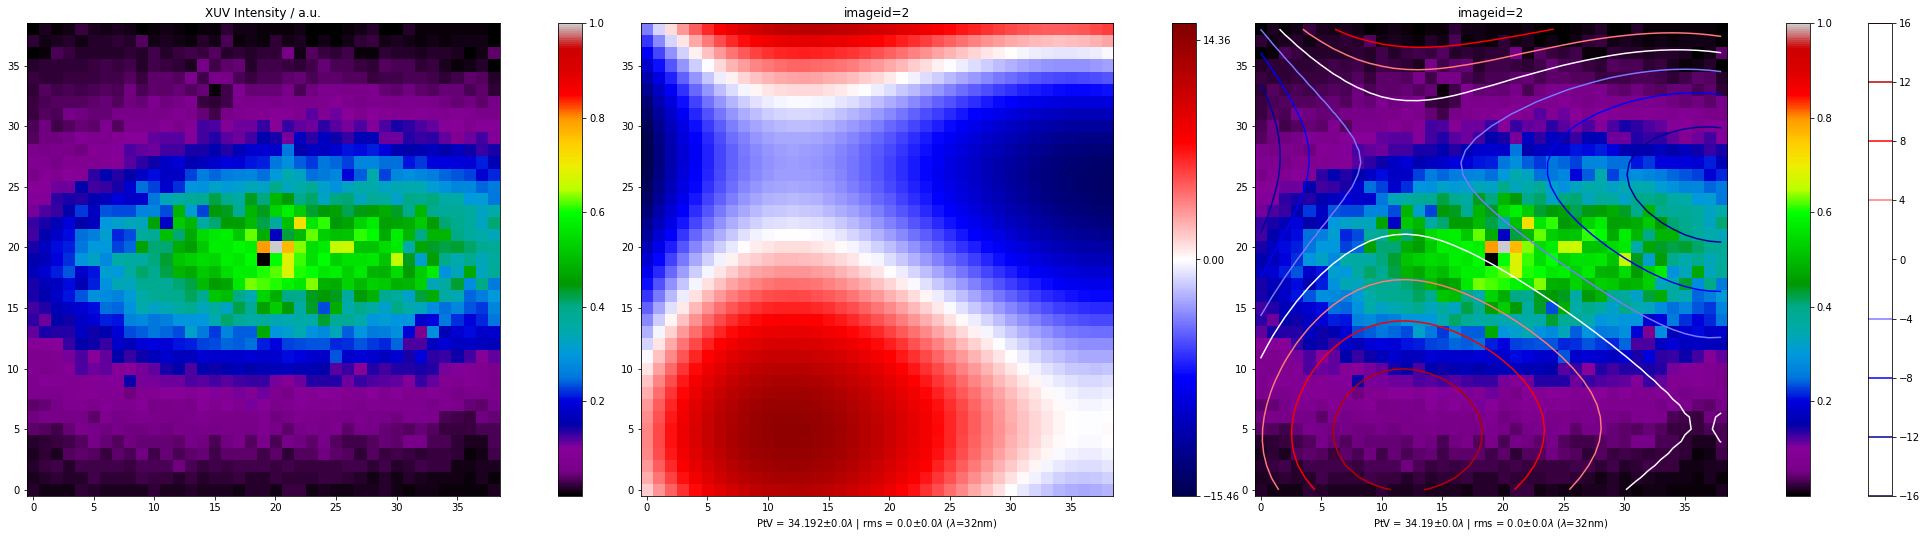

In [557]:
xuv_intensity_mean, \
xuv_wavefront_lambda_mean, \
xuv_intensity_pad_resize, \
xuv_wavefront_pad_resize_rad = plots(do_plots,
                                     do_savefigure,
                                     dataset,
                                     sequenceid_selection,
                                     sequenceid,
                                     XUV_imageid,
                                     xuv_do_average,
                                     xuv_postprocessing,
                                     xuv_clipped,
                                     xuv_offset,
                                     xuv_subAOI_mode,
                                     xuv_gridsize,
                                     xuv_gridtracking,
                                     xuv_z_idx,
                                     xuv_PeakIntensity_ScalingPerImage,
                                     xuv_PeakIntensity_min,
                                     xuv_PeakIntensity_max, 
                                     xuv_contourlevel,
                                     xuv_energythreshold,
                                     xuv_wf_range_auto, 
                                     xuv_wf_range, 
                                     xuv_magn, 
                                     profilewidth,
                                     xuvwaist_min, 
                                     xuvwaist_max,
                                     xuv_R,
                                     load_bp_files)

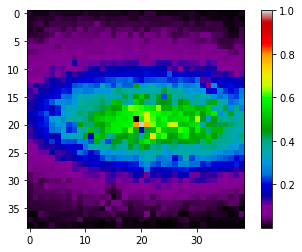

In [558]:
plt.imshow(xuv_intensity_mean, cmap='nipy_spectral')
plt.colorbar()

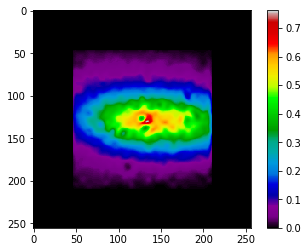

In [559]:
plt.imshow(xuv_intensity_pad_resize, cmap='nipy_spectral')
plt.colorbar()

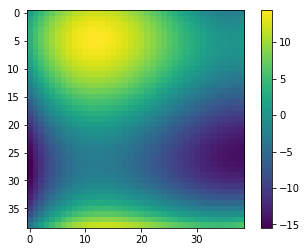

In [560]:
plt.imshow(xuv_wavefront_lambda_mean)
plt.colorbar()

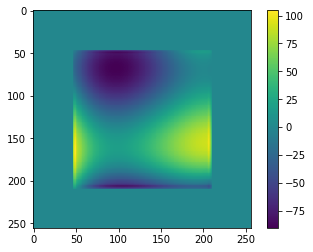

In [561]:
plt.imshow(xuv_wavefront_pad_resize_rad)
plt.colorbar()

In [562]:
xuv_wavelength_nm = 32



xuv_defocus_mm = xuv_defocus_mm * (-1)
xuv_V = xuv_magn

xuv_GridPitch_um = 250
xuv_pad_width = 11

NewN = 256
repeatBlurring = 8
xuv_intensity_pad_resize, xuv_wavefront_pad_resize_rad, xuv_GridDimension = pre_propagate(xuv_intensity_mean,xuv_wavefront_lambda_mean,xuv_pad_width,NewN, repeatBlurring)
xuv_wavefront_pad_resize_rad = xuv_wavefront_pad_resize_rad*(-1)

xuv_defocus_mm, xuvRayleighLengthX_mm, xuvRayleighLengthY_mm, xuvWaistPositionX_mm, xuvWaistPositionY_mm

(-390.716951, 3.766775, 6.938238, -387.062701, -394.899831)

In [0]:
# propagate to one position:
image_norm, wavefront_rad, image_size_x_m, Field = propagate(xuv_wavelength_nm, xuv_intensity_pad_resize, xuv_wavefront_pad_resize_rad, xuv_defocus_mm, xuv_V, -xuv_z1_mm, xuv_GridDimension, xuv_GridPitch_um, 1)

In [564]:
image_size_x_m*10e3

3.8124999999999996

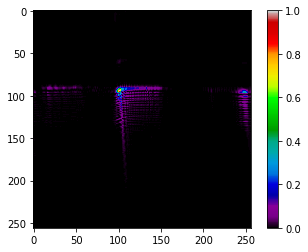

In [565]:
plt.imshow(image_norm, cmap='nipy_spectral')
plt.colorbar()

In [0]:
wavelength_nm = xuv_wavelength_nm
intensity = xuv_intensity_pad_resize
phase_rad = xuv_wavefront_pad_resize_rad
defocus_mm = xuv_defocus_mm
V = xuv_V 
z1_mm = -xuv_z1_mm

GridDimension = xuv_GridDimension
GridPitch_um = xuv_GridPitch_um
R = 1





GridPitch = GridPitch_um*1e-6
GridSize = GridDimension*GridPitch

N = 256
size = GridSize
wavelength = wavelength_nm*1e-9
#     R = GridSize/2

F0=lp.Begin(size,wavelength,N)
F0=lp.SubPhase(phase_rad,F0)

F0=lp.SubIntensity(intensity,F0) # this creates a spot thats 1 instead of 0 !!!!




# F0=lp.CircAperture(R, 0, 0, F0)

I=lp.Intensity(1,F0)
wavefront_rad=lp.Phase(F0)

if np.isinf(defocus_mm) == False:
    F0 = lp.Lens(defocus_mm*1e-3,0,0, F0)

# I=lp.Intensity(1,F0)
# wavefront_rad=lp.Phase(F0)
# #wavefront_rad=lp.PhaseUnwrap(wavefront_rad)

z1 = z1_mm*1e-3
z2 = -V*z1

f = V*z1 / (V-1)

F1 = lp.Lens(f,0,0,F0)

# F1 = lp.Forvard(z2,F1)

# I=lp.Intensity(1,F1)
# wavefront_rad=lp.Phase(F1)

#wavefront_rad=lp.PhaseUnwrap(wavefront_rad)

image_size_x_m = GridSize / V





image_norm = I
wavefront_rad = wavefront_rad
image_size_x_m = image_size_x_m
Field = F1

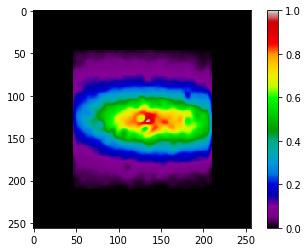

In [567]:
plt.imshow(image_norm, cmap='nipy_spectral')
plt.colorbar()

In [0]:
# generate array of propagated images:
xuv_image_norm_arr = []
xuv_image_intensity_arr = []
xuv_wavefront_rad_arr = []
xuv_magn_arr = []
xuv_image_size_x_m = []
xuv_pixelsize_m = []
xuv_maxposx_arr = []
xuv_maxposy_arr = []
xuv_fwhm_x_um_arr = []
xuv_fwhm_y_um_arr = []
xuv_sigma_x_um_arr = []
xuv_sigma_y_um_arr = []
xuv_radiusx_pos_arr = []
xuv_radiusx_neg_arr = []
xuv_radiusy_pos_arr = []
xuv_radiusy_neg_arr = []
xuv_PeakIntensity_arr = []
xuv_x0_px_arr = [] 
xuv_y0_px_arr = []

xuv_image_norm_arr, \
xuv_image_intensity_arr, \
xuv_wavefront_rad_arr, \
xuv_magn_arr, \
xuv_image_size_x_m, \
xuv_pixelsize_m, \
xuv_maxposx_arr, \
xuv_maxposy_arr, \
xuv_fwhm_x_um_arr, \
xuv_fwhm_y_um_arr, \
xuv_sigma_x_um_arr, \
xuv_sigma_y_um_arr, \
xuv_radiusx_pos_arr, \
xuv_radiusx_neg_arr, \
xuv_radiusy_pos_arr, \
xuv_radiusy_neg_arr, \
xuv_PeakIntensity_arr, \
xuv_x0_px_arr, \
xuv_y0_px_arr, \
xuv_phi_arr = generate_propagation_arrays(xuv_wavelength_nm, 
                                          xuv_intensity_pad_resize, 
                                          xuv_wavefront_pad_resize_rad, 
                                          xuv_defocus_mm, 
                                          xuv_V, 
                                          -xuv_z_mm_arr, 
                                          xuv_GridDimension, 
                                          xuv_GridPitch_um, 
                                          False, 
                                          False, 
                                          1,
                                          0, 
                                          True, 
                                          False,
                                          xuv_R)

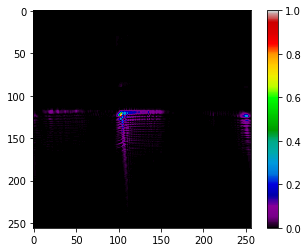

In [569]:
plt.imshow(xuv_image_norm_arr[xuv_z_idx], cmap='nipy_spectral')
plt.colorbar()

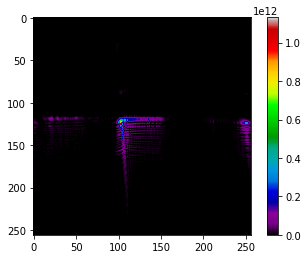

In [570]:
plt.imshow(xuv_image_intensity_arr[xuv_z_idx], cmap='nipy_spectral')
plt.colorbar()

In [0]:
#caustic plots
            
# along x (fixed y)
# ax29 = plt.subplot(gs[2,9])

causticx = xuv_image_intensity_arr[1:-2,128,:]
# causticx = xuv_image_norm_arr[1:-2,128,:]
#             causticx = np.rot90(causticx)
causticx = np.rot90(causticx)
causticx = np.flipud(causticx)
#causticx = np.fliplr(causticx)
# ax29.imshow(causticx,cmap=ir_colormap, vmin=0, vmax=xuv_PeakIntensity_max, interpolation='nearest', aspect='auto', extent=[xuv_z_mm_arr[1], xuv_z_mm_arr[-2], 0, 500], origin='lower')
# ax29.contour(causticx,levels=[xuv_contourlevel * 1e9], colors=['yellow'], extent=[xuv_z_mm_arr[1], xuv_z_mm_arr[-2], 0, 500], linewidths=3)
# ax09.contour(causticx,levels=[xuv_contourlevel * 1e9], colors=['white'], extent=[ir_z_mm_arr[1], ir_z_mm_arr[-2], 0, 500], linewidths=3, linestyles='dotted')
# xposition = [-3506, -3521]
# for xc in xposition:
#     ax29.axvline(x=xc, color='w', linestyle='--', linewidth=3)

# along y (fixed x)
# ax29.set_xticks([xuv_z_mm_arr[-2], -3506, -3521, xuv_z_mm_arr[1]])
# ax39 = plt.subplot(gs[3,9])

causticy = xuv_image_intensity_arr[1:-2,:,128]
# causticy = xuv_image_norm_arr[1:-2,:,128]
#             causticy = np.rot90(causticy)
causticy = np.rot90(causticy)            
causticy = np.flipud(causticy)
#causticy = np.fliplr(causticy)
# ax39.imshow(causticy,cmap=ir_colormap, vmin=0, vmax=xuv_PeakIntensity_max, interpolation='nearest', aspect='auto', extent=[xuv_z_mm_arr[1], xuv_z_mm_arr[-2], 0, 500], origin='lower')
# ax39.contour(causticy,levels=[xuv_contourlevel * 1e9], colors=['yellow'], extent=[xuv_z_mm_arr[1], xuv_z_mm_arr[-2],0, 500], linewidths=3)
# ax19.contour(causticy,levels=[xuv_contourlevel * 1e9], colors=['white'], extent=[ir_z_mm_arr[1], ir_z_mm_arr[-2], 0, 500], linewidths=3, linestyles='dotted')
# xposition = [-3506, -3521]
# for xc in xposition:
#     ax39.axvline(x=xc, color='w', linestyle='--', linewidth=3)
# ax39.set_xticks([xuv_z_mm_arr[-2], -3506, -3521, xuv_z_mm_arr[1]])

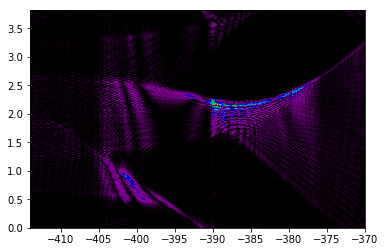

In [572]:
plt.imshow(causticx, interpolation='nearest', aspect='auto', cmap='nipy_spectral', extent=[xuv_z_mm_arr[0], xuv_z_mm_arr[-1],0, image_size_x_m*10e3])

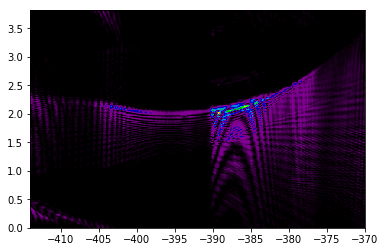

In [573]:
plt.imshow(causticy, interpolation='nearest', aspect='auto', cmap='nipy_spectral', extent=[xuv_z_mm_arr[0], xuv_z_mm_arr[-1],0, image_size_x_m*10e3])

In [0]:
#caustic plots
            
# along x (fixed y)
# ax29 = plt.subplot(gs[2,9])

# causticx = xuv_image_intensity_arr[1:-2,128,:]
causticx = xuv_image_norm_arr[1:-2,128,:]
#             causticx = np.rot90(causticx)
causticx = np.rot90(causticx)
causticx = np.flipud(causticx)
#causticx = np.fliplr(causticx)
# ax29.imshow(causticx,cmap=ir_colormap, vmin=0, vmax=xuv_PeakIntensity_max, interpolation='nearest', aspect='auto', extent=[xuv_z_mm_arr[1], xuv_z_mm_arr[-2], 0, 500], origin='lower')
# ax29.contour(causticx,levels=[xuv_contourlevel * 1e9], colors=['yellow'], extent=[xuv_z_mm_arr[1], xuv_z_mm_arr[-2], 0, 500], linewidths=3)
# ax09.contour(causticx,levels=[xuv_contourlevel * 1e9], colors=['white'], extent=[ir_z_mm_arr[1], ir_z_mm_arr[-2], 0, 500], linewidths=3, linestyles='dotted')
# xposition = [-3506, -3521]
# for xc in xposition:
#     ax29.axvline(x=xc, color='w', linestyle='--', linewidth=3)

# along y (fixed x)
# ax29.set_xticks([xuv_z_mm_arr[-2], -3506, -3521, xuv_z_mm_arr[1]])
# ax39 = plt.subplot(gs[3,9])

# causticy = xuv_image_intensity_arr[1:-2,:,128]
causticy = xuv_image_norm_arr[1:-2,:,128]
#             causticy = np.rot90(causticy)
causticy = np.rot90(causticy)            
causticy = np.flipud(causticy)
#causticy = np.fliplr(causticy)
# ax39.imshow(causticy,cmap=ir_colormap, vmin=0, vmax=xuv_PeakIntensity_max, interpolation='nearest', aspect='auto', extent=[xuv_z_mm_arr[1], xuv_z_mm_arr[-2], 0, 500], origin='lower')
# ax39.contour(causticy,levels=[xuv_contourlevel * 1e9], colors=['yellow'], extent=[xuv_z_mm_arr[1], xuv_z_mm_arr[-2],0, 500], linewidths=3)
# ax19.contour(causticy,levels=[xuv_contourlevel * 1e9], colors=['white'], extent=[ir_z_mm_arr[1], ir_z_mm_arr[-2], 0, 500], linewidths=3, linestyles='dotted')
# xposition = [-3506, -3521]
# for xc in xposition:
#     ax39.axvline(x=xc, color='w', linestyle='--', linewidth=3)
# ax39.set_xticks([xuv_z_mm_arr[-2], -3506, -3521, xuv_z_mm_arr[1]])

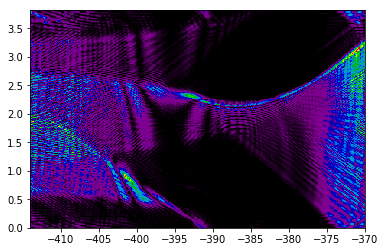

In [578]:
plt.imshow(causticx, interpolation='nearest', aspect='auto', cmap='nipy_spectral', extent=[xuv_z_mm_arr[0], xuv_z_mm_arr[-1],0, image_size_x_m*10e3])

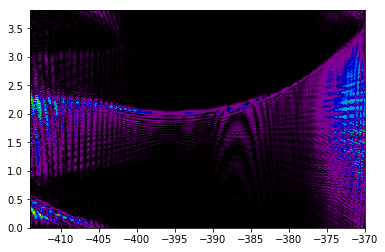

In [579]:
plt.imshow(causticy, interpolation='nearest', aspect='auto', cmap='nipy_spectral', extent=[xuv_z_mm_arr[0], xuv_z_mm_arr[-1],0, image_size_x_m*10e3])

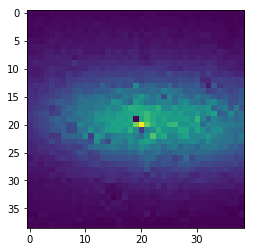

In [574]:
plt.imshow(xuv_intensity_mean)

In [0]:
def interactive_plots(XUV_imageid):
  do_plots = True
  do_savefigure = True

  do_plots = True
  do_savefigure = False
  dataset = 'VOXEL_20180411'
  sequenceid_selection = [10]
  sequenceid = 10
  # XUV_imageid = 1
  xuv_do_average = False
  xuv_postprocessing = ''
  xuv_clipped = 0
  xuv_offset = 0
  xuv_subAOI_mode = 'auto'
  xuv_gridsize = 39
  xuv_gridtracking = 'auto'
  # xuv_z_idx = 17
      
  xuv_PeakIntensity_ScalingPerImage = True
  xuv_PeakIntensity_min = 1
  xuv_PeakIntensity_max = 1
  xuv_contourlevel =1
  xuv_energythreshold = 1
  xuv_wf_range_auto = True
  xuv_wf_range = [0,1]
  xuv_magn = 80
  profilewidth = 10
  xuvwaist_min = -405
  xuvwaist_max = -375
  xuv_R = 1

  load_bp_files = False

  xuv_z_mm_arr = np.arange(-1*xuvwaist_min+0.5,-1*xuvwaist_max-1,-0.5)
  xuv_z_mm_arr = xuv_z_mm_arr * (-1)
  xuv_z_idx = np.where(xuv_z_mm_arr == -390)[0][0]
  xuv_intensity_mean = plots(do_plots,do_savefigure,dataset,sequenceid_selection,sequenceid,XUV_imageid,xuv_do_average,xuv_postprocessing,xuv_clipped,xuv_offset,xuv_subAOI_mode,xuv_gridsize,xuv_gridtracking,xuv_z_idx,        
            xuv_PeakIntensity_ScalingPerImage,xuv_PeakIntensity_min,xuv_PeakIntensity_max, xuv_contourlevel,
            xuv_energythreshold,
            xuv_wf_range_auto, xuv_wf_range, 
            xuv_magn, profilewidth,
          xuvwaist_min, xuvwaist_max, xuv_R,
      load_bp_files)
  


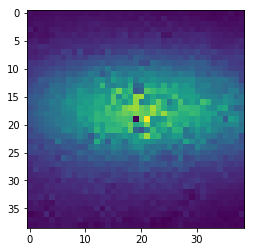

In [395]:
plt.imshow(xuv_intensity_mean)

In [396]:
widgets.interact(interactive_plots,XUV_imageid=widgets.IntSlider(min=1, max=10, step=1, value=1));

interactive(children=(IntSlider(value=1, description='XUV_imageid', max=10, min=1), Output()), _dom_classes=('…

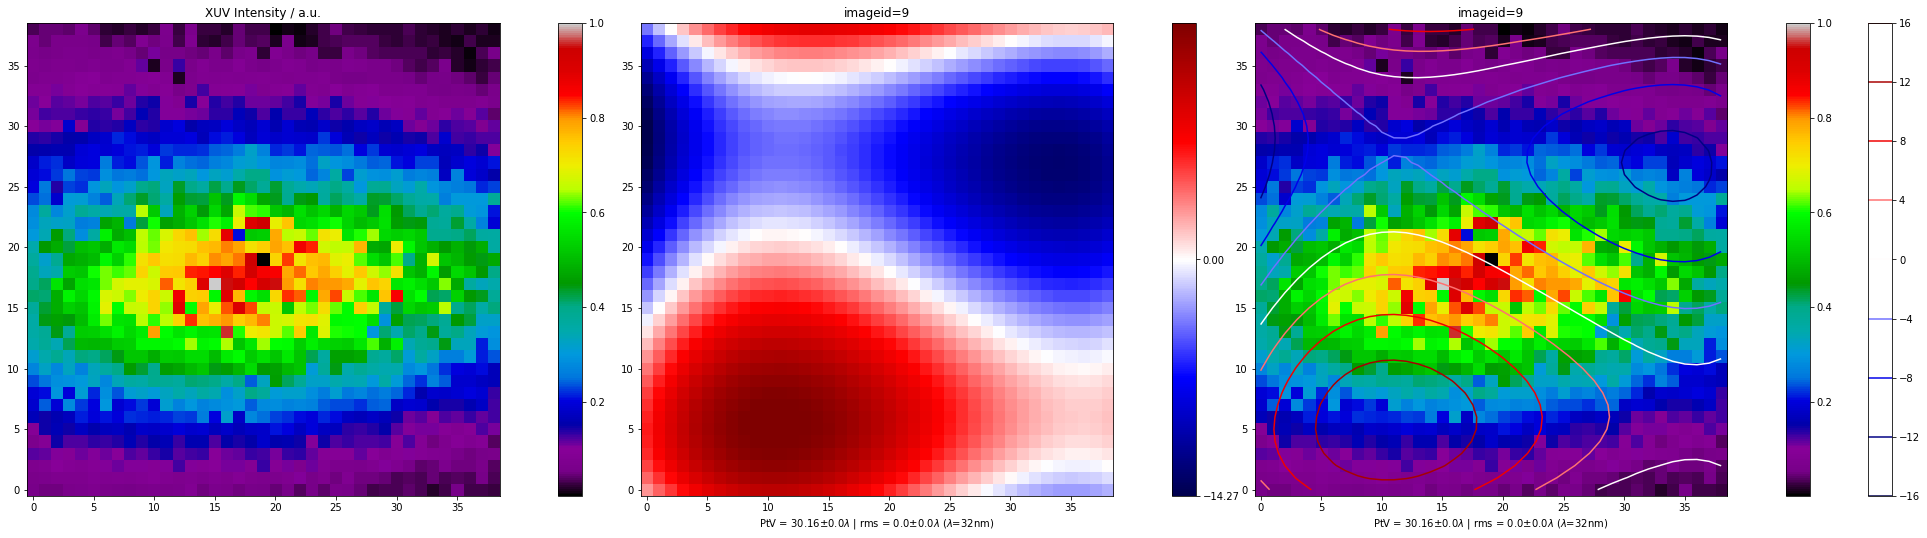

In [397]:
interactive_plots(9)